In [86]:
# Import required packages
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import json
import time

import plotly.express as px
import plotly.io as pio
import ast

from itertools import combinations
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [87]:
# Set up request
headers = {"User-Agent": "Mozilla/5.0"}
cookies = {
    "birthtime": "1004572800",
    "lastagecheckage": "1-November-2001" 
}

# Get soup from top sellers page
topsellers_search_url = "https://store.steampowered.com/search/?filter=topsellers"
topsellers_search_page = requests.get(topsellers_search_url, headers=headers, cookies=cookies)
topsellers_soup = BeautifulSoup(topsellers_search_page.text, "html.parser")

# Get soup from indie page 
indie_search_url = "https://store.steampowered.com/search/?tags=492&supportedlang=english&filter=topsellers&ndl=1"
indie_search_page = requests.get(indie_search_url, headers=headers, cookies=cookies)
indie_soup = BeautifulSoup(indie_search_page.text, "html.parser")


In [90]:
# Find top sellers
topsellers_results = topsellers_soup.select('a.search_result_row')
indie_results = indie_soup.select('a.search_result_row')

def extract_game_data(soup_results):
    game_data = []

    for result in soup_results:
        url = result['href'].split('?')[0]
        title = result.select_one('.title').text.strip()

        price_block = result.select_one('.search_price, .search_price_discount_combined')
        if price_block:
            # Extract text and clean it
            price_text = price_block.get_text(separator=' ', strip=True).replace('Free', '$0.00')
            prices = re.findall(r'[\$€£]\d+(?:\.\d{2})?', price_text)
            price = prices[-1] if prices else price_text.strip() or "Unknown"

            if price != "Unknown":
                price = re.sub(r'[\$€£]', '', price)

                if float(price) > 150:
                    continue # Skip if price is greater than 150 (Steam Deck and other expensive non-games)
        else:
            price = "Unknown"


        game_data.append({
            "title": title,
            "url": url,
            "price": price
        })
    
    return game_data

In [91]:
topsellers_data = extract_game_data(topsellers_results)
indie_data = extract_game_data(indie_results)

In [92]:
# For each game, extract the tags
def extract_tags_from_game(url):
    try:
        game_page = requests.get(url, headers=headers, cookies=cookies)
        soup = BeautifulSoup(game_page.text, "html.parser")
        for script in soup.find_all("script"):
            if "InitAppTagModal" in script.text:
                match = re.search(r'InitAppTagModal\(\s*\d+,\s*(\[\{.*?\}\])', script.text)
                if match:
                    tag_data_json = match.group(1)
                    tag_data = json.loads(tag_data_json)
                    return [tag["name"] for tag in tag_data]
    except Exception as e:
        print(f"Error processing {url}: {e}")
    return []

In [93]:
# Collect tags for the top games
for i, game in enumerate(topsellers_data):
    print(f"Processing {game['title']} - {game['url']}")
    tags = extract_tags_from_game(game["url"])
    topsellers_data[i]["tags"] = tags
    time.sleep(0.5)

Processing RuneScape: Dragonwilds - https://store.steampowered.com/app/1374490/RuneScape_Dragonwilds/
Processing Counter-Strike 2 - https://store.steampowered.com/app/730/CounterStrike_2/
Processing Schedule I - https://store.steampowered.com/app/3164500/Schedule_I/
Processing Marvel Rivals - https://store.steampowered.com/app/2767030/Marvel_Rivals/
Processing Last Epoch - https://store.steampowered.com/app/899770/Last_Epoch/
Processing R.E.P.O. - https://store.steampowered.com/app/3241660/REPO/
Processing Tempest Rising - https://store.steampowered.com/app/1486920/Tempest_Rising/
Processing Baldur's Gate 3 - https://store.steampowered.com/app/1086940/Baldurs_Gate_3/
Processing Lords of the Fallen - https://store.steampowered.com/app/1501750/Lords_of_the_Fallen/
Processing Blue Prince - https://store.steampowered.com/app/1569580/Blue_Prince/
Processing The Elder Scrolls® Online - https://store.steampowered.com/app/306130/The_Elder_Scrolls_Online/
Processing War Thunder - https://store.

In [94]:
# Collect tags for the top indie games
for i, game in enumerate(indie_data):
    print(f"Processing {game['title']} - {game['url']}")
    tags = extract_tags_from_game(game["url"])
    indie_data[i]["tags"] = tags
    time.sleep(0.5)

Processing Last Epoch - https://store.steampowered.com/app/899770/Last_Epoch/
Processing Blue Prince - https://store.steampowered.com/app/1569580/Blue_Prince/
Processing Last Epoch - Woven Legend Supporter Pack - https://store.steampowered.com/app/3512600/Last_Epoch__Woven_Legend_Supporter_Pack/
Processing Drive Beyond Horizons - https://store.steampowered.com/app/2625420/Drive_Beyond_Horizons/
Processing Rust - https://store.steampowered.com/app/252490/Rust/
Processing Phasmophobia - https://store.steampowered.com/app/739630/Phasmophobia/
Processing Enshrouded - https://store.steampowered.com/app/1203620/Enshrouded/
Processing Ravenfield - https://store.steampowered.com/app/636480/Ravenfield/
Processing Last Epoch - Woven Vanquisher Supporter Pack - https://store.steampowered.com/app/3512590/Last_Epoch__Woven_Vanquisher_Supporter_Pack/
Processing Void Crew - https://store.steampowered.com/app/1063420/Void_Crew/
Processing Aviassembly - https://store.steampowered.com/app/2660460/Aviass

In [95]:
# Clean up and simplify data
# Remove redundant 'indie' tag from indie games
for game in indie_data:
    if 'Indie' in game['tags']:
        game['tags'] = [tag for tag in game['tags'] if tag != 'Indie']

# Save raw data to CSV files
topsellers_df = pd.DataFrame(topsellers_data)
topsellers_df.to_csv("steam_top_sellers_data.csv", index=False)
indie_df = pd.DataFrame(indie_data)
indie_df.to_csv("steam_indie_data.csv", index=False)

tag_simplification_map = {
    "4 Player Local": "Co-op",
    "Online Co-Op": "Co-op",
    "Local Co-Op": "Co-op",
    "Co-op Campaign": "Co-op",
    "Local Multiplayer": "Co-op",
    "Split Screen": "Co-op",
    "Party Game": "Co-op",
    "Lore-Rich": "Story Rich",
    "Action Roguelike": "Roguelike",
    "Roguelite": "Roguelike", # For simplicity I am classifying these as roguelikes (I know they're different)
    "Job Simulator": "Simulation",
    "Immersive Sim": "Simulation",
    "Farming Sim": "Simulation",
    "Dating Sim": "Simulation",
    "Automobile Sim": "Simulation",
    "Life Sim": "Simulation",
    "Colony Sim": "Simulation",
    "Action Adventure": "Action",
    "Card Battler": "Card Game",
    "Nudity": "Sexual Content",
    "NSFW": "Sexual Content",
    "Great Soundtrack": "Soundtrack",
    "Tactical RPG": "Tactical",
    "Board Game": "Tabletop",
    "War": "Military",
    "Wargame": "Military",
    "World War II": "Military",
    "Cold War": "Military",
    "Cyberpunk": "Sci-Fi",
    "Dark Fantasy": "Fantasy",
    "Old School": "Retro",
    "Kickstarter": "Crowdfunded",
    "Psychological Horror": "Horror",
    "Survival Horror": "Horror",
    "Thriler": "Horror",
    "Side Scroller": "Platformer",
    "2D Platformer": "Platformer",
    "Base Building": "Building"
    # Add more mappings as needed
}

# Simplify tags in the data
for game in topsellers_data:
    simplified_tags = []
    for tag in game['tags']:
        simplified_tags.append(tag_simplification_map.get(tag, tag))  # Replace if match, else keep
    game['tags'] = list(set(simplified_tags))  # Remove duplicates

# Apply the simplification to indie_data
for game in indie_data:
    simplified_tags = []
    for tag in game['tags']:
        simplified_tags.append(tag_simplification_map.get(tag, tag))
    game['tags'] = list(set(simplified_tags))

In [96]:
# Run if you want updated data as top sellers change frequently

topsellers_df = pd.DataFrame(topsellers_data)
topsellers_df.to_csv("steam_top_sellers_data_simple.csv", index=False)
indie_df = pd.DataFrame(indie_data)
indie_df.to_csv("steam_indie_data_simple.csv", index=False)

In [97]:

def plot_tags(df, title, chart_type, top_n=20):
    # Convert stringified lists to actual lists
    if isinstance(df['tags'].iloc[0], str):
        df['tags'] = df['tags'].apply(ast.literal_eval)

    # Explode the tag lists into individual rows
    exploded_tags = df.explode('tags')

    # Count tag frequencies
    tag_counts = exploded_tags['tags'].value_counts().reset_index().head(top_n)
    tag_counts.columns = ['tag', 'count']

    # Set up the plot
    plt.figure(figsize=(18, 10))
    
    if chart_type == 0:  # Bar chart
        plt.bar(tag_counts['tag'], tag_counts['count'], color='skyblue')
        plt.title(title)
        plt.xlabel('Tag')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()

    else:  # Pie chart
        tag_counts = tag_counts.head(top_n)
        plt.pie(tag_counts['count'], labels=tag_counts['tag'], autopct='%1.1f%%', startangle=140)
        plt.title(title)
        plt.axis('equal')  # Equal aspect ratio ensures the pie is circular

    plt.show()


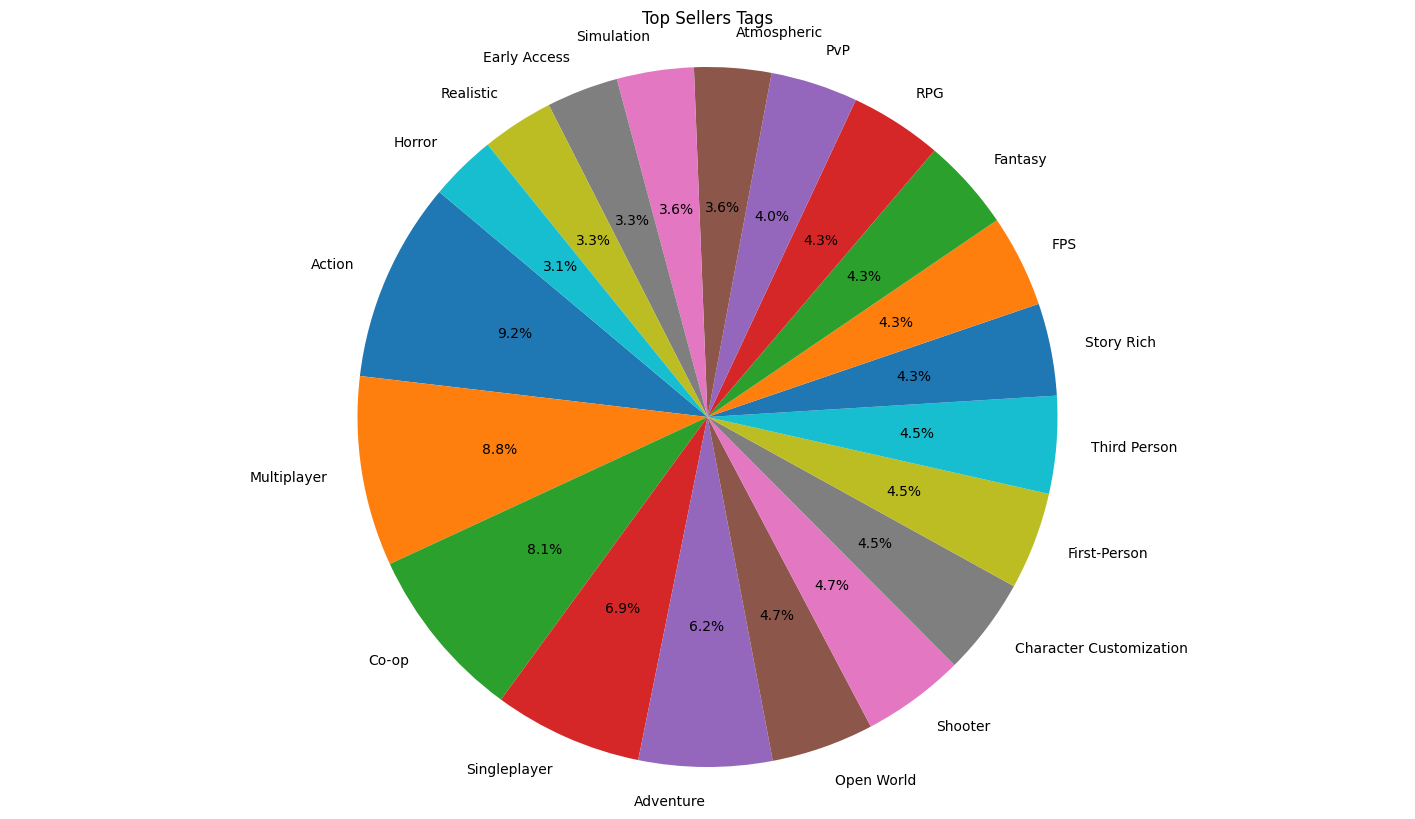

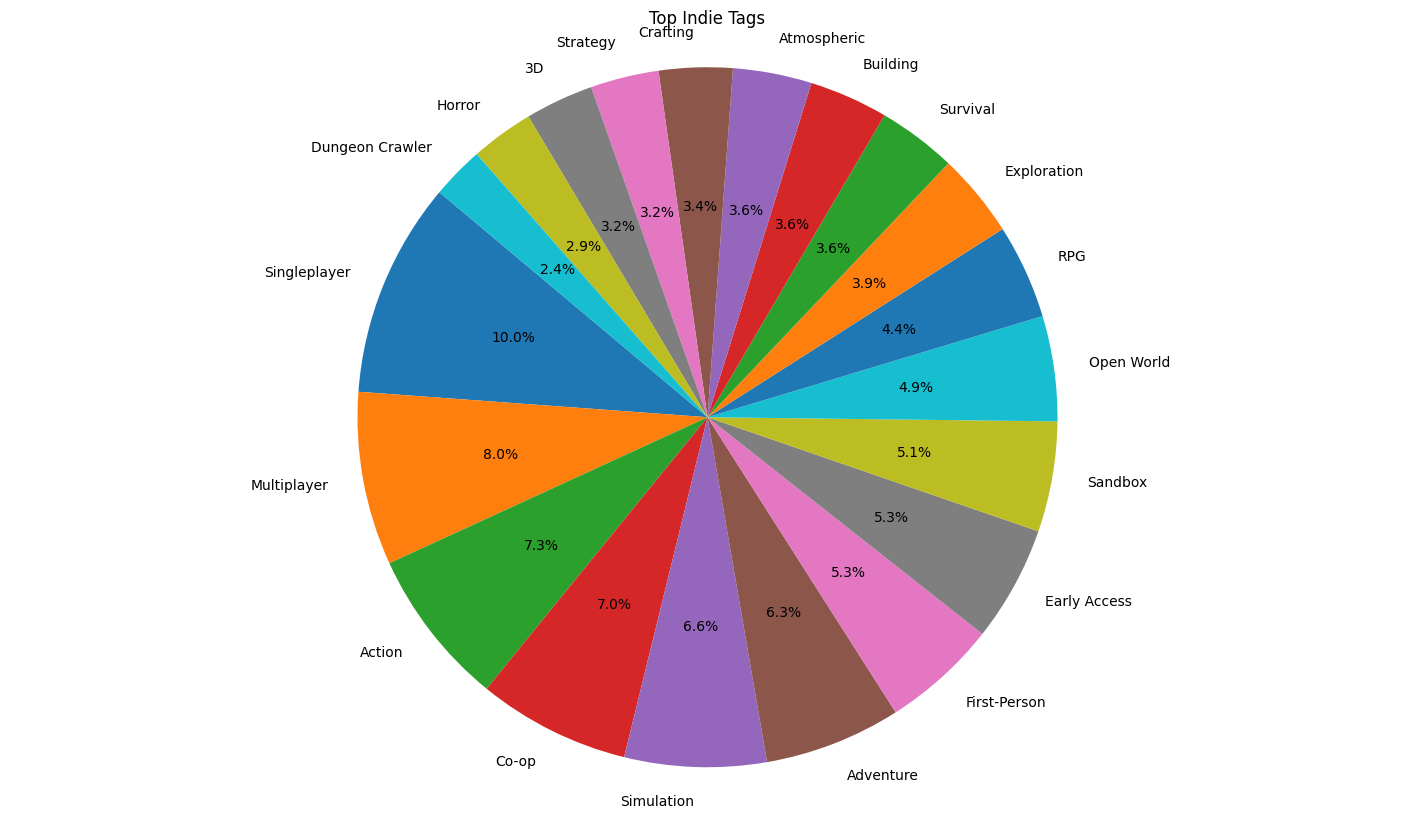

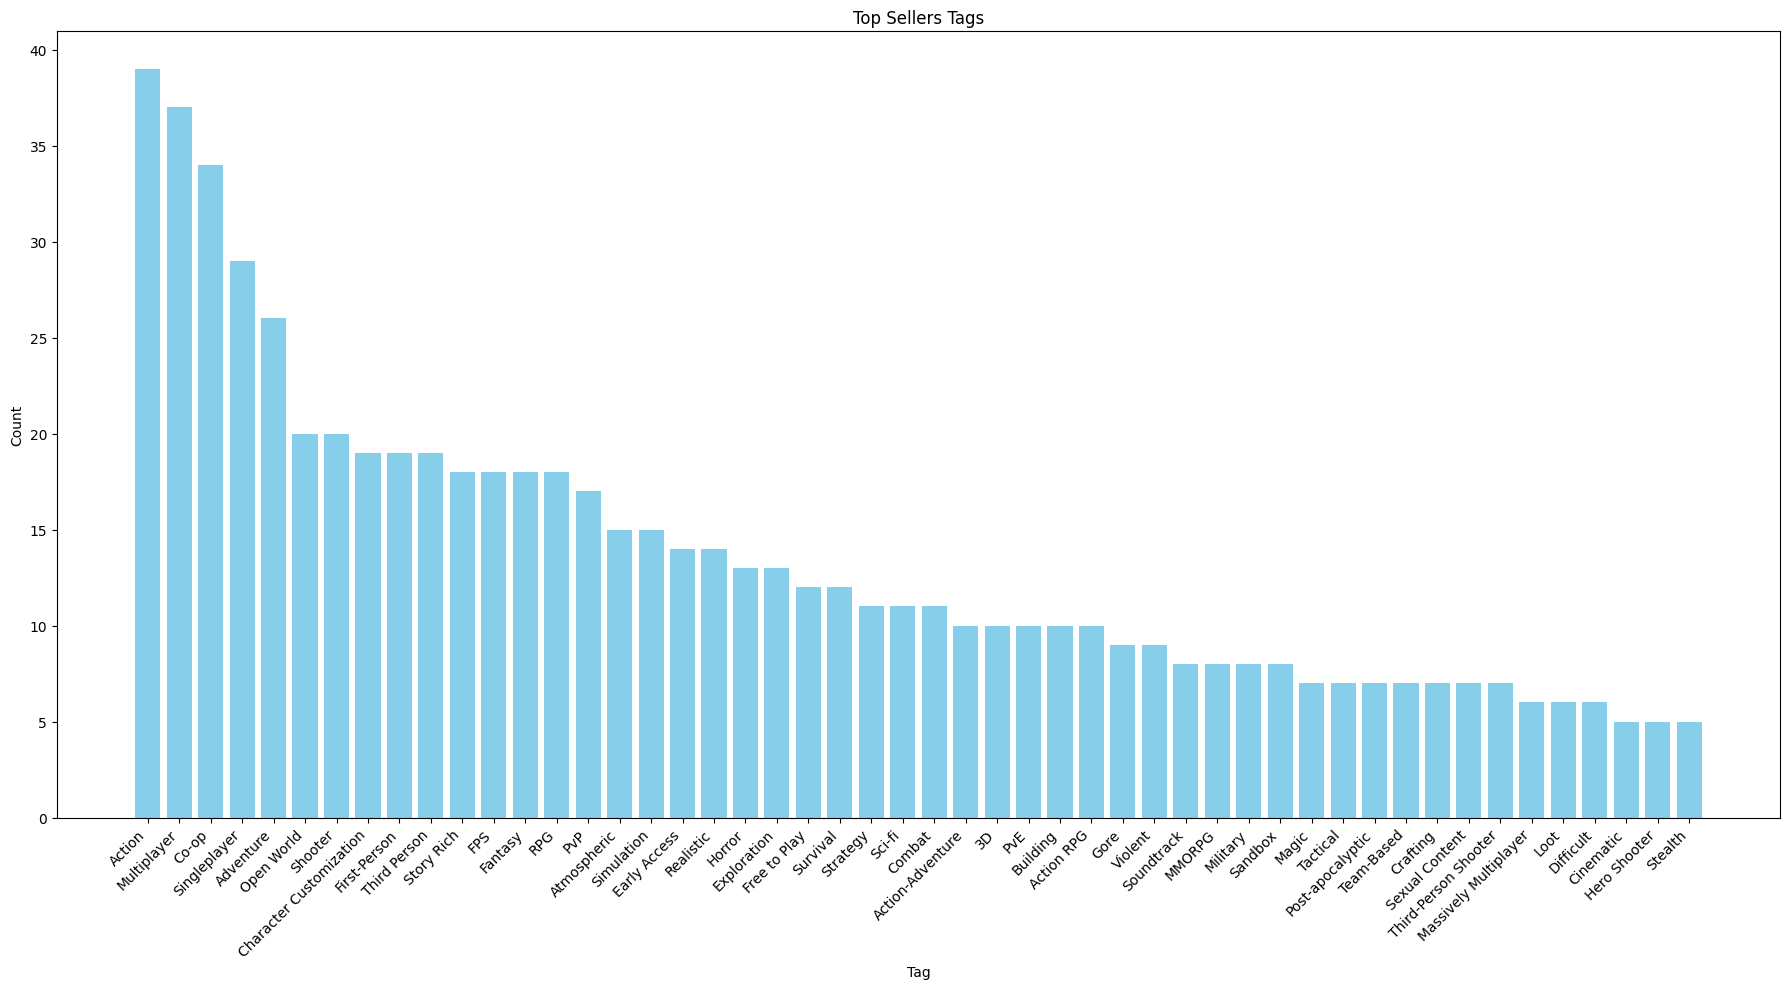

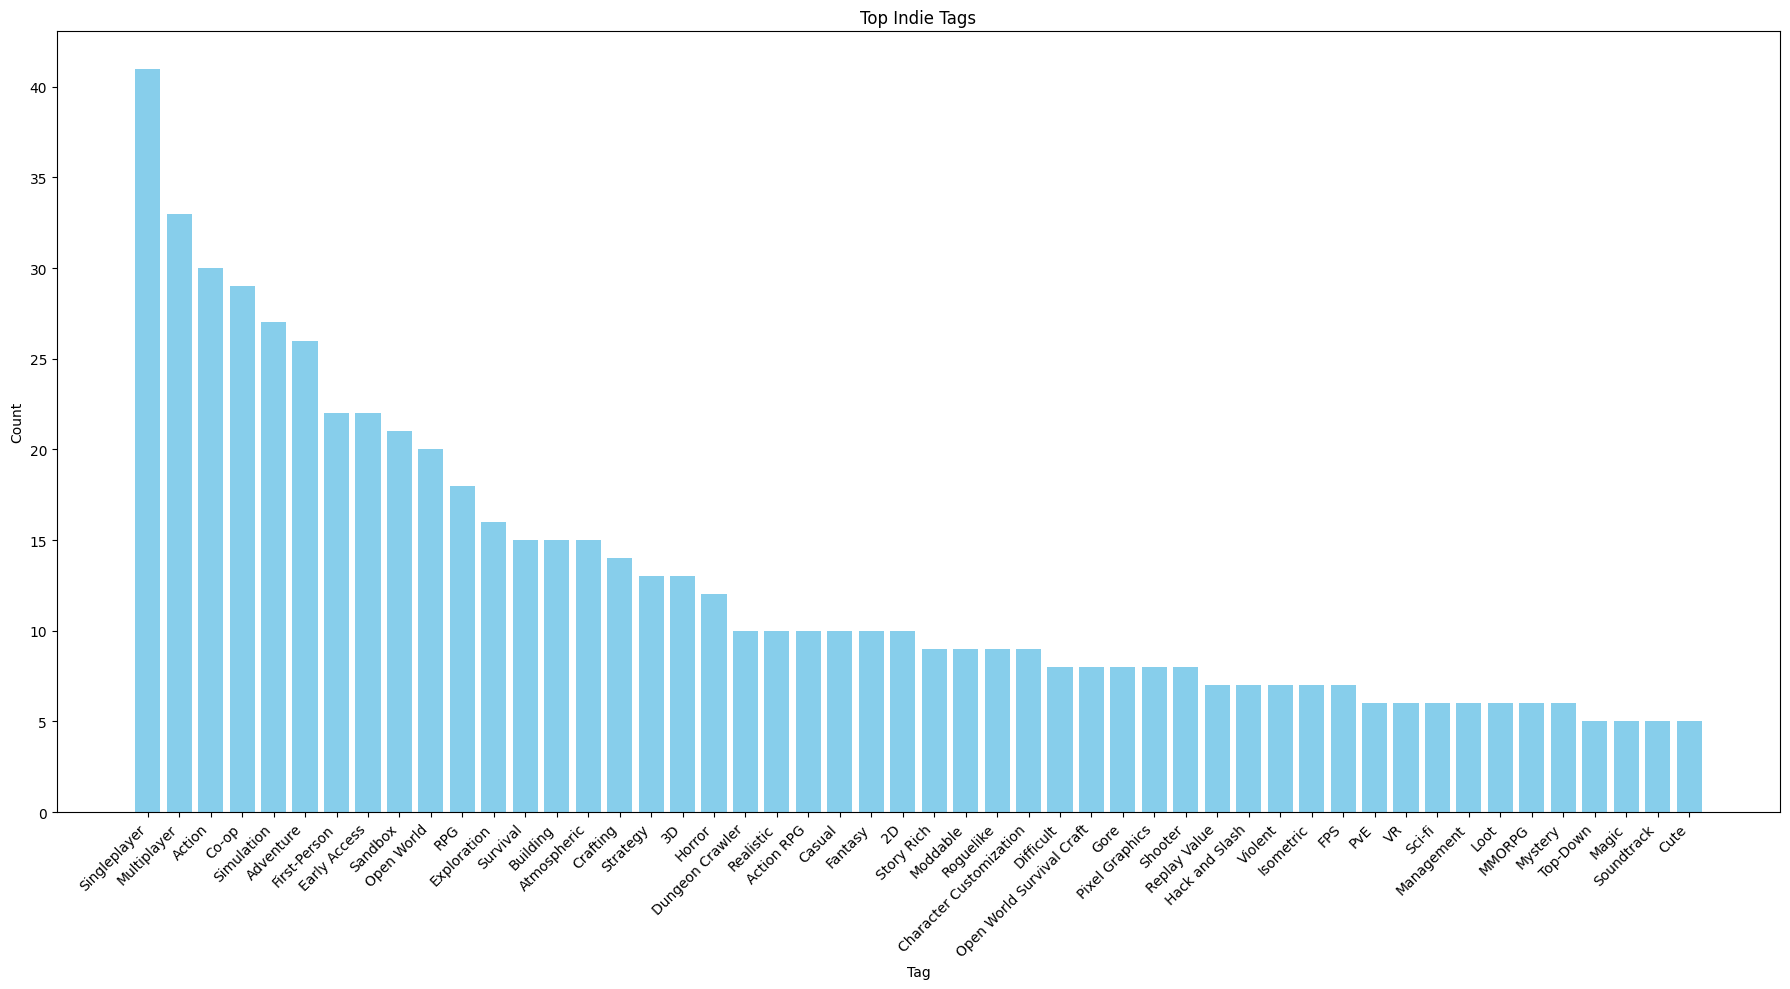

The average price of top sellers is $28.76
The median price of top sellers is $29.24
The average price of indies is $22.63
The median price of indies is $19.99


In [98]:
# Surface level of top tags
topsellers_df = pd.read_csv("steam_top_sellers_data_simple.csv")
indie_df = pd.read_csv("steam_indie_data_simple.csv")

plot_tags(topsellers_df, "Top Sellers Tags", 1)
plot_tags(indie_df, "Top Indie Tags", 1)
plot_tags(topsellers_df, "Top Sellers Tags", 0, 50)
plot_tags(indie_df, "Top Indie Tags", 0, 50)

# Get average price for all games
topsellers_df['price'] = pd.to_numeric(topsellers_df['price'], errors='coerce')
indie_df['price'] = pd.to_numeric(indie_df['price'], errors='coerce')

topsellers_mean = topsellers_df['price'].mean()
indie_mean = indie_df['price'].mean()

topsellers_median = topsellers_df['price'].median()
indie_median = indie_df['price'].median()

print(f'The average price of top sellers is ${topsellers_mean:.2f}')
print(f'The median price of top sellers is ${topsellers_median:.2f}')

print(f'The average price of indies is ${indie_mean:.2f}')
print(f'The median price of indies is ${indie_median:.2f}')


In [99]:
# Calculate tag co-occurrences and create a matrix

def create_tag_cooccurrence_matrix(df):
    # Make sure tags are lists, not strings
    if isinstance(df['tags'].iloc[0], str):
        df['tags'] = df['tags'].apply(ast.literal_eval)

    pair_counts = Counter()

    for tag_list in df['tags']:
        unique_tags = set(tag_list)
        for tag1, tag2 in combinations(sorted(unique_tags), 2):
            pair_counts[(tag1, tag2)] += 1

    # Convert to square matrix format
    tag_list = sorted({tag for pair in pair_counts for tag in pair})
    matrix = pd.DataFrame(0, index=tag_list, columns=tag_list)

    for (tag1, tag2), count in pair_counts.items():
        # Make Symmetric
        matrix.loc[tag1, tag2] = count
        matrix.loc[tag2, tag1] = count 

    return matrix


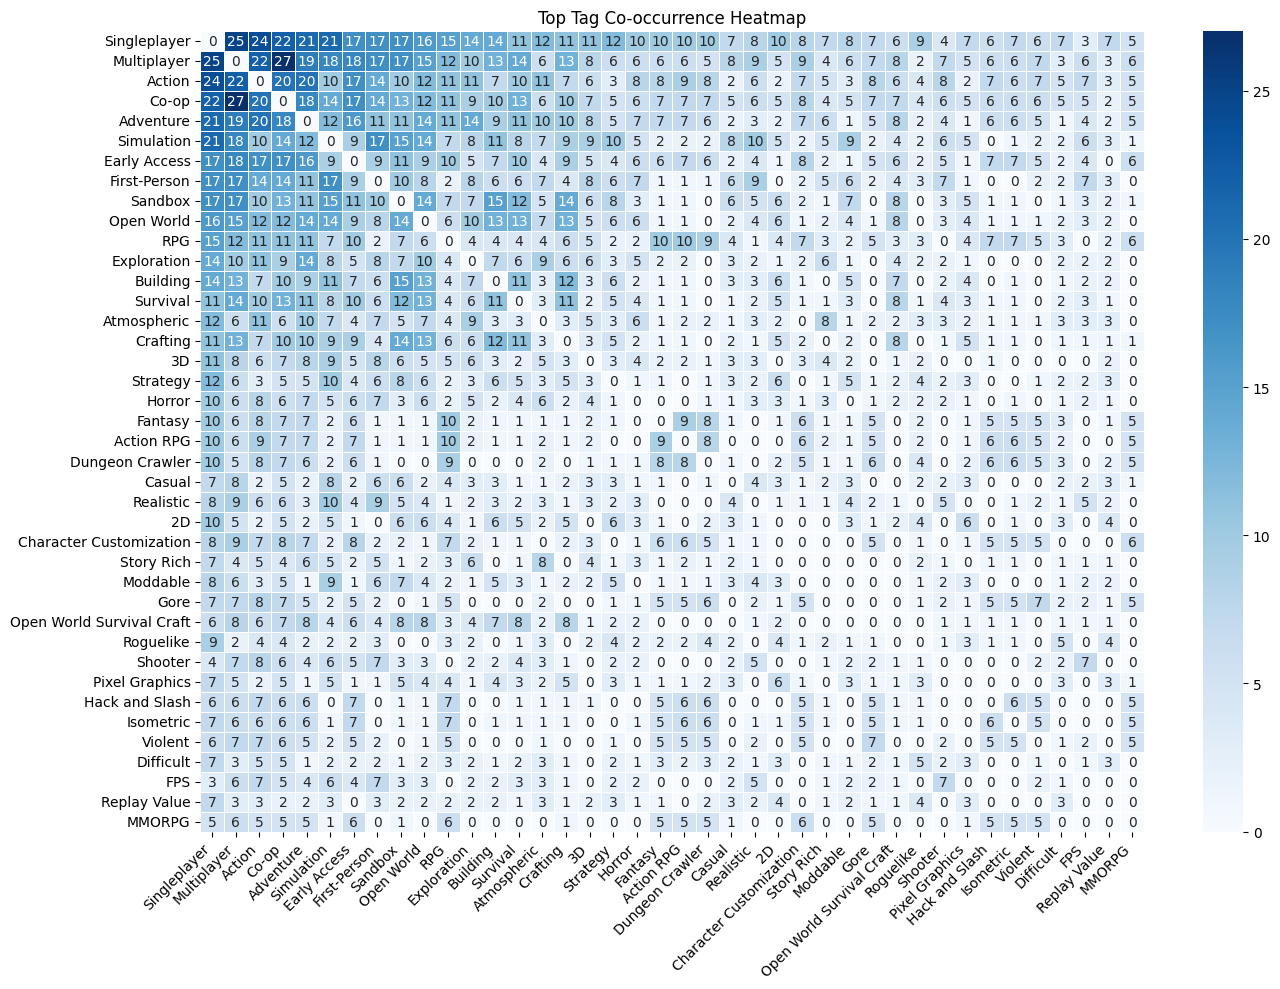

In [ ]:
cooccurrence_matrix = create_tag_cooccurrence_matrix(indie_df)

# Focus on most frequent tags
top_tags = cooccurrence_matrix.sum().sort_values(ascending=False).head(40).index
filtered_matrix = cooccurrence_matrix.loc[top_tags, top_tags]

plt.figure(figsize=(14, 10))
sns.heatmap(filtered_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title("Top Indie   Tag Co-occurrence Heatmap")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()